In [2]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [3]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import cat2hpx, pandas_to_fits, my_scaler_forward
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
import nway_python_api as nway
%matplotlib inline

matplotlib settings set


matplotlib settings set
This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py


# LH X-ray catalog

little work with X-ray catalog: duplicates and extended sources

In [4]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl')
xcat_orig = xcat_orig.query('EXT==0')
xcat_orig.sort_values(by = 'ML_FLUX_0', ascending=False, inplace=True)
xcat_orig = xcat_orig.drop_duplicates(subset=['srcname_fin'])

def cross_match_with_itself(xcat, ra_col = 'RA_fin', dec_col = 'DEC_fin', err_col='pos_r98'):
    xcat_matched = xcat.copy()
    c = SkyCoord(ra=xcat[ra_col]*u.degree, dec=xcat[dec_col]*u.degree)
    catalog = SkyCoord(ra=xcat[ra_col]*u.degree, dec=xcat[dec_col]*u.degree)
    idx, ero2ero, _ = c.match_to_catalog_sky(catalog, nthneighbor=2)
    ero2ero = ero2ero.to(u.arcsec).value

    xcat_matched['sep_to_closest'] = ero2ero
    xcat_matched.loc[:, 'srcname_fin_closest']  = xcat_matched.iloc[idx]['srcname_fin'].values
    xcat_matched = xcat_matched.merge(xcat.rename(columns={'srcname_fin':'srcname_fin_closest'}), on='srcname_fin_closest', how='left', suffixes=('', '_closest'))

    xcat_matched['is_confused'] = xcat_matched.eval('sep_to_closest<sqrt( pos_r98**2 + pos_r98_closest**2 )/2 & sep_to_closest<30')

    xcat_matched['ML_FLUX_0_ratio'] = xcat_matched.ML_FLUX_0/xcat_matched.ML_FLUX_0_closest
    xcat_matched['ML_CTS_0_ratio']  = xcat_matched.ML_CTS_0/xcat_matched.ML_CTS_0_closest
    xcat_matched['DET_LIKE_0_ratio'] = xcat_matched.DET_LIKE_0/xcat_matched.DET_LIKE_0_closest
    xcat_matched['sep_ero2ero'] = xcat_matched['sep_to_closest']
    xcat_matched['pos_r98_first'] = xcat_matched['pos_r98']
    xcat_matched['pos_r98_second'] = xcat_matched['pos_r98_closest']
    xcat_matched['should_be_deleted'] = (xcat_matched['is_confused']) &  (xcat_matched['ML_FLUX_0_ratio']<1) #so that we delete the one with lower ML_FLUX_0
    
    xcat_matched = xcat_matched[['srcname_fin', 'srcname_fin_closest', 'is_confused', 'ML_FLUX_0_ratio', 'ML_CTS_0_ratio', 'DET_LIKE_0_ratio', 'sep_ero2ero', 'pos_r98_first', 'pos_r98_second', 'should_be_deleted']]

    return xcat_matched
xcat_matched = cross_match_with_itself(xcat_orig)


id_to_retain = xcat_matched[xcat_matched.should_be_deleted==False]['srcname_fin']
xcat_orig = xcat_orig[xcat_orig.srcname_fin.isin(id_to_retain)]
xcat_orig.reset_index(drop=True, inplace=True) #nway works with indeces only


In [5]:

xcat_orig.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

Read catalog and create a fits table with positions and positional errors

In [6]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

positional_error_columns = 'pos_sigma_2d'
print('*'*50)
print('using positional error columns:', positional_error_columns)


columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', positional_error_columns, 'ML_FLUX_0'] 


xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat[positional_error_columns] = 0.9*xcat[positional_error_columns]

xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', positional_error_columns:'pos_err', 'srcname_fin': 'ID'}, inplace=True)


print('using corrected positional error columns: 0.9*', positional_error_columns)
print('*'*50)

xcat['pos_err'] = xcat['pos_err']

**************************************************
using positional error columns: pos_sigma_2d
using corrected positional error columns: 0.9* pos_sigma_2d
**************************************************


## area and plotting

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel
18.116940169675424 sq. deg.


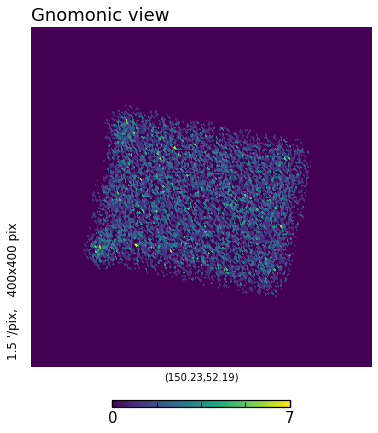

In [7]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [8]:
pandas_to_fits(dataframe = xcat, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)

In [9]:
xcat[['RA', 'DEC']].describe().loc[['min', 'max']]

,RA,DEC
min,154.763934,54.124219
max,167.084550,61.236185


## Random catalog

In [15]:
# nway.create_shifted_catalogue(inputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits', outputfile=data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits', shift_dec=300, radius=40)